# Isolation Forest Unsupervised Model

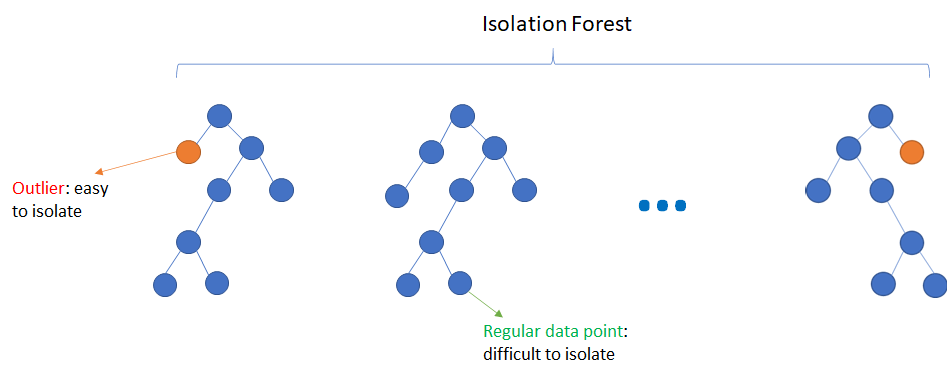

**Links**\
[Scikit-Learn IForests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)\
[IForest Outlier Detection on KDD'99 Dataset](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/od_if_kddcup.html)\
[Someone's Notebook on a IForest Model](https://github.com/Apress/beginning-anomaly-detection-using-python-based-dl/blob/master/Isolation%20Forest%20KDDCUP%201999%20final.ipynb)


**Definition**\
The Isolation Forest (iForest) model is an unsupervised model that focuses more on isolating outliers rather than profiling normal behavior.  

Isolation Trees (iTrees) are constructed by recursively partitioning the data. For each node in an iTree, a feature is randomly selected, and a random split within the feature’s range is chosen. The process is repeated until every data point is isolated in its own leaf node, or a predetermined height limit is reached.  

In the iForest structure, every data point has a path length, the number of edges traversed from the root node to the leaf node that contains it. The idea is that anomalous data points tend to have shorter path lengths because they require less partitions to isolate. The iForest model can then assign an anomaly score, based on the path length to perform a binary classification of normal and anomalous data points.

**IForests for Anomaly Detection With KDD'99**\
With isolation models’ approach of partitioning data, they do not suffer from the ‘curse of dimensionality’, the model can remain performant and reliable even with high dimension datasets such as KDD99. Additionally, having a linear time complexity makes iForest models suitable for massive datasets, such as KDD99. This makes iForest a great model choice for a real time intrusion detection system, where it's important to quickly identify anomalies. 

 

Network intrusions are supposed to be ‘few and different’ compared to normal traffic, iForest models excel at isolating such traffic. The model makes no data distribution assumptions, complex and non-standard distribution in network traffic won't make the model's performance suffer. 

In [1]:
## Import everything, define parameters and dropped features.
# Load the prepared data and apply variance threshold to it.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from common_stage import prepareData

# Hyperparameters
hyperparams = {
    'n_estimators': 100,  # The number of base estimators
    'contamination': 0.21, # The amount of contamination expected in the data (proportion of outliers). Used for defining the threshold.
    'max_samples': 48,  # The number of samples to draw from the data frames to train each base estimator
    'max_features': 1.0,   # The number of features to draw from the data frames to train each base estimator
    'variance_threshold': 0.0,
    'pca_components': 0.95
}

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard')

# Apply variance threshold to remove low-variance features
vt = VarianceThreshold(hyperparams['variance_threshold'])
x_train = vt.fit_transform(x_train)
x_test = vt.transform(x_test)

# Remove features, so that X% of variance is retained
if(hyperparams['pca_components'] < 1.0):
    pca = PCA(hyperparams['pca_components'], svd_solver='full', random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

# Convert x_train and x_test back to dataframes after PCA
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

y_test_binary = np.where(y_test == 0, 0, 1)
y_train_binary = np.where(y_train == 0, 0, 1)

print("Data Frames After Processing Stage:")
print(x_train.shape)
print(x_test.shape)

Data Frames After Processing Stage:
(493969, 11)
(292261, 11)


---
## Grid Search for Best Hyperparameters
```python
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest

def auc_scorer(estimator, X, y):
    preds = np.where(estimator.predict(X) == -1, 1, 0)
    return roc_auc_score(y, preds)

# Grid search parameters
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_samples': [0.1, 0.3, 0.6, 0.9],
    'max_features': [0.1, 0.5, 0.8, 1.0]
}

# Perform Grid Search
grid = GridSearchCV(
    IsolationForest(contamination=hyperparams['contamination']),
    param_grid=param_grid,
    scoring=make_scorer(auc_scorer),
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(x_train, y_train_binary)

print("Best Parameters:", grid.best_params_)
```
---

In [2]:
## Define and fit the Isolation Forest model

from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=hyperparams['n_estimators'],
    contamination=hyperparams['contamination'],
    max_samples=hyperparams['max_samples'],
    max_features=hyperparams['max_features'],
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
iso_forest.fit(x_train)

IsolationForest(bootstrap=True, contamination=0.21, max_samples=48, n_jobs=-1,
                random_state=42)

In [3]:
## Make Predictions and give anomaly scores.

# Anomaly Score (the higher, the more normal)
anomaly_score = iso_forest.decision_function(x_test)
anomaly_preds = np.where(iso_forest.predict(x_test) == -1, 1, 0)
x_test['anomaly_score'] = anomaly_score
x_test['anomaly'] = anomaly_preds

n_anomalies = np.sum(x_test['anomaly'] == 1)
percent_anomalies = (n_anomalies / len(x_test['anomaly'])) * 100

print("Isolation Forest Evaluation (Test Set):")
print(f"Total samples: {len(x_test['anomaly'])}")
print(f"Anomalies detected: {n_anomalies}")
print(f"Percentage anomalies: {percent_anomalies:.2f}%")

Isolation Forest Evaluation (Test Set):
Total samples: 292261
Anomalies detected: 96489
Percentage anomalies: 33.01%


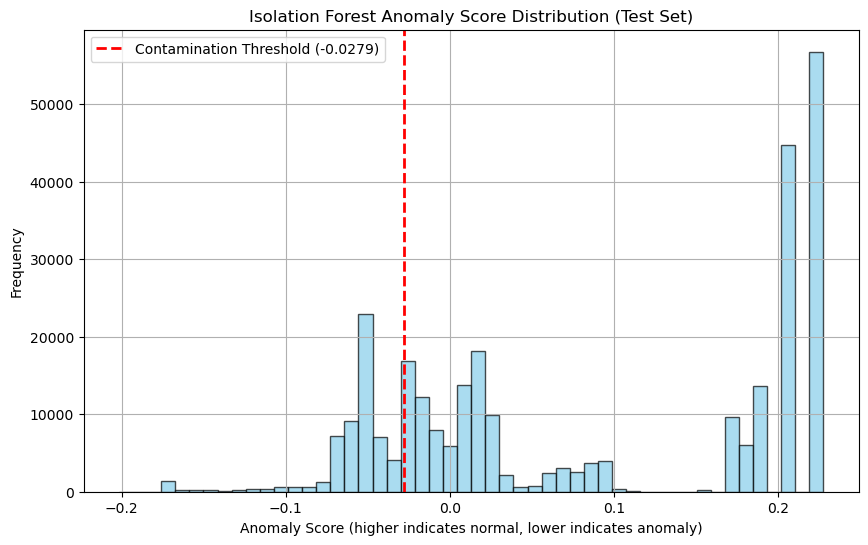

In [4]:
## Create a plot of the anomaly score distribution

threshold = np.percentile(x_test['anomaly_score'], 100 * hyperparams['contamination'])
plt.figure(figsize=(10, 6))
plt.hist(x_test['anomaly_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Contamination Threshold ({threshold:.4f})')
plt.title("Isolation Forest Anomaly Score Distribution (Test Set)")
plt.xlabel("Anomaly Score (higher indicates normal, lower indicates anomaly)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

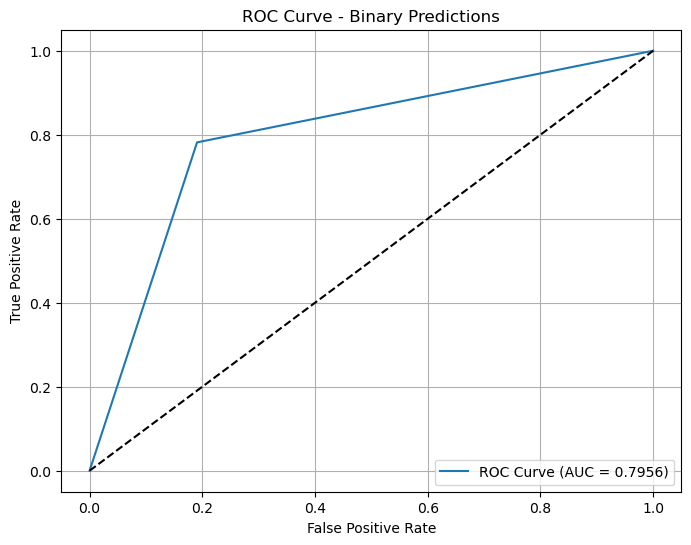

ROC AUC Score: 0.7956


In [5]:
## ROC AUC Curve
# Evaluates the performance of binary classification models. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) -
# at different thresholds showing how well a model can distinguish between two classes.

# AUC (Area Under the Curve) measures the area under the ROC curve. A higher AUC suggests better model performance; as it can distinguish between the classes better.
# An AUC of 1 means that the model is perfectly distinguishing the classes of datapoints. 0.5 Suggests that the model is essentially randomly guessing.

from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test_binary, x_test['anomaly'])

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, x_test['anomaly'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Predictions')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

In [6]:
## Get the Root Mean Squared Error - RMSE measures the average magnitude of the errors between predicted and actual values.
# It is considered an excellent general-puprose error metric for numerical predictions.
# A lower score is better, it is feature dependent, sensitive to outliers but an easy way to compare models.

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_binary, x_test['anomaly'])
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.4440263374563826


In [7]:
## Evalutate Anomaly Detection

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score


print("Classification Report:")
print(classification_report(y_test_binary, x_test['anomaly'], target_names=["Normal", "Anomaly"], zero_division=0))

# Calculate evaluation metrics
precision = precision_score(y_test_binary, x_test['anomaly'], zero_division=0)
recall = recall_score(y_test_binary, x_test['anomaly'], zero_division=0)
f1 = f1_score(y_test_binary, x_test['anomaly'], zero_division=0)
accuracy = accuracy_score(y_test_binary, x_test['anomaly'])

print("\nEvaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.81      0.86    223298
     Anomaly       0.56      0.78      0.65     68963

    accuracy                           0.80    292261
   macro avg       0.74      0.80      0.76    292261
weighted avg       0.84      0.80      0.81    292261


Evaluation Metrics:
Accuracy:  0.8028
Precision: 0.5588
Recall:    0.7818
F1 Score:  0.6517


Number of samples with label 0 (normal): 223298
Number of samples with label 1 (anomaly): 68963


<Figure size 800x600 with 0 Axes>

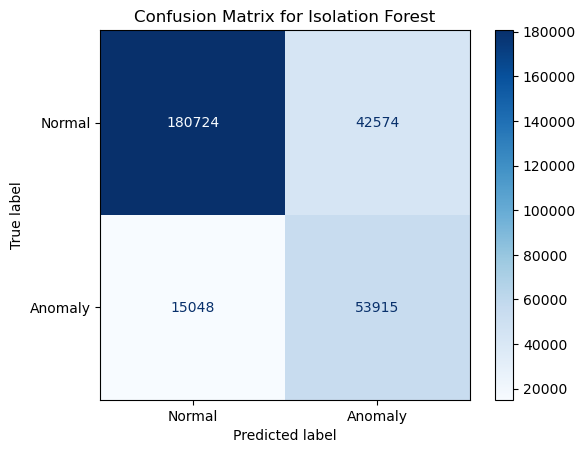

In [8]:
## Make a Confusion Matrix Plot

from sklearn.metrics import ConfusionMatrixDisplay

print("Number of samples with label 0 (normal):", np.sum(y_test_binary == 0))
print("Number of samples with label 1 (anomaly):", np.sum(y_test_binary == 1))

cm = confusion_matrix(y_test_binary, x_test['anomaly'])
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Isolation Forest')
plt.grid(False)
plt.show()